# Genres that yield highest net profit

To understand what kind of films are worth a production investment, we'll look at data sets containing gross revenue, production costs, genres and general film distribution data such as title and the year of release.

note: to create the movie.db locally, run the notebook SQLiteDatabase.ipynb

In [1]:
#necessary imports

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#changing the display settings to only format floats

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

## Overall, what are the top 5 films with the highest net revenue?

In [11]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  t.year, SUM(t.worldwide_gross-t.production_budget) as movieBudget_netRevenue_$,
  t.movie as movieBudget_title, b.title as boxOfficeMojo_title, 
  t.worldwide_gross as movieBudget_Worldwide_$,
  t.production_budget as movieBudget_Production_$, 
  t.domestic_gross as movieBudget_Domestic_$,
  b.domestic_gross as boxOfficeMojo_Domestic_$,
  b.foreign_gross as boxOfficeMojo_foreign_$
FROM tn_movie_budgets t 
LEFT JOIN bom_movie_gross b
ON t.movie = b.title
GROUP BY t.movie
ORDER BY movieBudget_netRevenue_$ DESC
LIMIT 5
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft

,year,movieBudget_netRevenue_$,movieBudget_title,boxOfficeMojo_title,movieBudget_Worldwide_$,movieBudget_Production_$,movieBudget_Domestic_$,boxOfficeMojo_Domestic_$,boxOfficeMojo_foreign_$
0,2009,2351345279,Avatar,None,2776345279,425000000,760507625,nan,None
1,1997,2008208395,Titanic,None,2208208395,200000000,659363944,nan,None
2,2018,1748134200,Avengers: Infinity War,Avengers: Infinity War,2048134200,300000000,678815482,678800000.00,"1,369.5"
3,2015,1747311220,Star Wars: Episode VII - The Force Awakens,None,2053311220,306000000,936662225,nan,None
4,2017,1687630838,Beauty and the Beast,None,1259199706,160000000,504014165,nan,None


***Findings***: We found that values were rounded and titles were missing in the Box Office Mojo file and decided to use the Budget dataset as true values. We also found through comparison of both datasets that the worldwide revenue included both domestic and foreign gross. So, this is the total gross revenue. 

The top 5 net revenue films are:
1. $2.4B Avatar

2. $2.0B Titanic

3. $1.748B Avengers: Infinity War

4. $1.747B Star Wars Ep. VII: The Force Awakens

5. $1.69B Beauty and the Beast


### If available, what are the genres of those top 5 films? 

In [17]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  t.year, t.movie as movieBudget_title, i.genre_action, 
i.genre_adult, i.genre_adventure, i.genre_animation, i.genre_biography, 
i.genre_comedy, i.genre_crime, i.genre_documentary, i.genre_drama, i.genre_family, 
i.genre_fantasy, i.genre_gameshow, i.genre_history, i.genre_horror, i.genre_music, 
i.genre_musical, i.genre_mystery, i.genre_news, i.genre_realitytv, i.genre_romance, 
i.genre_scifi, i.genre_short, i.genre_sport, i.genre_talkshow, i.genre_thriller, 
i.genre_war, i.genre_western
FROM tn_movie_budgets t 
LEFT JOIN imdb_title_basics i
ON t.movie = i.primary_title
WHERE (i.primary_title == 'Beauty and the Beast') & (i.tconst == 'tt2771200') 
& (t.year like '%17%') OR (i.primary_title == 'Avatar') OR 
(i.primary_title == 'Titanic') OR (i.primary_title like '%Infinity War%') & 
(i.primary_title like '%Avengers%') OR (i.primary_title like '%Star War%') & 
(i.primary_title like '%Ep%') & (i.primary_title like '%Force Awakens%')
GROUP BY t.movie
;
""")


dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft

,year,movieBudget_title,genre_action,genre_adult,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,genre_fantasy,genre_gameshow,genre_history,genre_horror,genre_music,genre_musical,genre_mystery,genre_news,genre_realitytv,genre_romance,genre_scifi,genre_short,genre_sport,genre_talkshow,genre_thriller,genre_war,genre_western
0,2009,Avatar,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018,Avengers: Infinity War,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2017,Beauty and the Beast,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,2015,Star Wars: Episode VII - The Force Awakens,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1997,Titanic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


***Findings***: Looking at the IMDB dataset, we found the titles of the top 5 net revenue films and noted the identified genres for each film. The genres include action, adventure, family, fantasy, horror, music, musical and sci-fi.  

Additional note: the film "Beauty and Beast" returned multiple listings, but with a quick online search, we found the appropriate IMDB film ID that matched the 2017 release. We also joined the Budget dataset as a double check for the appropriate year.

## Top 5 grossing films by year

### What are the titles of the films?

In [9]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  t.year, t.worldwide_gross grossRevenue_$,
  t.movie as movieTitle
FROM tn_movie_budgets t 
GROUP BY t.movie
ORDER BY grossRevenue_$ DESC
LIMIT 5
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft

,year,grossRevenue_$,movieTitle
0,2009,2776345279,Avatar
1,1997,2208208395,Titanic
2,2015,2053311220,Star Wars: Episode VII - The Force Awakens
3,2018,2048134200,Avengers: Infinity War
4,2015,1648854864,Jurassic World


***Findings***: The movie budget dataset shows us that the top 5 grossing films were released between the years 1997 and 2018. And, most of these films match the list of top 5 net revenue films with the exception of 'Jurassic World'. This indicates that production cost brought down the net revenue for outlying the film.

### So, what was the production cost for these top grossing films?

In [25]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  t.year, t.movie as movieTitle, t.production_budget as productionCost_$, 
  SUM(t.worldwide_gross-t.production_budget) as movieBudget_netRevenue_$, 
  t.worldwide_gross as grossRevenue_$
FROM tn_movie_budgets t 
GROUP BY t.movie
ORDER BY grossRevenue_$ DESC
LIMIT 5
;
""")


dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft.head()

,year,movieTitle,productionCost_$,movieBudget_netRevenue_$,grossRevenue_$
0,2009,Avatar,425000000,2351345279,2776345279
1,1997,Titanic,200000000,2008208395,2208208395
2,2015,Star Wars: Episode VII - The Force Awakens,306000000,1747311220,2053311220
3,2018,Avengers: Infinity War,300000000,1748134200,2048134200
4,2015,Jurassic World,215000000,1433854864,1648854864


***Findings***: The data show that the lowest production budget spend was on 'Titanic' and ranged to $425 million for the most expensive budget on 'Avatar'.

note: 'Jurassic World' had a lower production budget similar to 'Titanic' but did not bring in enough gross revenue to bring the film into the top 5 net revenue films. It trailed 'Titanic' by $5.6M in overall gross revenue. 

We also noticed that 'Avatar' had the highest spend in production budget but yeilded the highest overall gross and net revenues.

### What was the runtime?

In [30]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT i.tconst as IMDB_id, t.year, i.primary_title as Movie, i.runtime_minutes
FROM imdb_title_basics i
LEFT JOIN tn_movie_budgets t 
ON i.primary_title = t.movie
WHERE (i.primary_title == 'Beauty and the Beast') & (i.tconst == 'tt2771200') 
& (t.year like '%17%') OR (i.primary_title == 'Avatar') OR 
(i.primary_title == 'Titanic') OR (i.primary_title like '%Infinity War%') & 
(i.primary_title like '%Avengers%') OR (i.primary_title like '%Star War%') & 
(i.primary_title like '%Ep%') & (i.primary_title like '%Force Awakens%')
GROUP BY i.primary_title
ORDER BY i.runtime_minutes
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())

dft

,IMDB_id,year,Movie,runtime_minutes
0,tt1775309,2009,Avatar,93.00
1,tt8852130,1997,Titanic,115.00
2,tt2771200,2017,Beauty and the Beast,129.00
3,tt2488496,2015,Star Wars: Episode VII - The Force Awakens,136.00
4,tt4154756,2018,Avengers: Infinity War,149.00


***Findings***: From the IMDB dataset, we can see that the movies ranged in runtime from 93 — 149 minutes. Since there is nearly an hour difference between the shortest and longest runtimes, this indicates that there is no correlation between runtime and net revenue.

## Most recently, what has been the average production cost by year? 

In [19]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT 
  year, AVG(production_budget) as average_Budget_$, COUNT(movie) as number_of_Movies
FROM tn_movie_budgets 
GROUP BY year
ORDER BY year DESC
LIMIT 10
;
""")

dft = pd.DataFrame(cur.fetchall())
dft.columns = (x[0] for x in cur.description)
#print(dft.shape)
print(dft.info())

dft.head(11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              10 non-null     object 
 1   average_Budget_$  10 non-null     float64
 2   number_of_Movies  10 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 368.0+ bytes
None


,year,average_Budget_$,number_of_Movies
0,2020,94000000.00,3
1,2019,52738955.22,67
2,2018,48138860.14,143
3,2017,50030732.14,168
4,2016,40973698.63,219
5,2015,26160294.08,338
6,2014,30405519.11,255
7,2013,37392382.35,238
8,2012,36115468.82,235
9,2011,35247843.70,254


***Findings***: The average production costs range from $ 26 - 94 Million in the past 10 years

## Of the 5 highest box office revenue films, what genres were represented?

In the Rotten Tomatoes dataset, is there a common genre associated with highest box office revenue?

In [32]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT box_office as box_office_$, genre_action, genre_adventure, genre_animation, genre_classics, 
genre_comedy, genre_documentary, genre_drama, 
genre_horror, genre_international, genre_kids, 
genre_muscial, genre_mystery, genre_scifi, 
genre_spirituality, genre_sports, genre_romance,
genre_television, genre_western
FROM rt_reviews
JOIN rt_movie_info
USING('pid')  
ORDER BY box_office DESC
LIMIT 5;""")

pd.set_option('display.max_columns', None)
dfgBox = pd.DataFrame(cur.fetchall())
dfgBox.columns = (x[0] for x in cur.description)
#print(dft.shape)
#print(dft.info())
dfgBox

,box_office_$,genre_action,genre_adventure,genre_animation,genre_classics,genre_comedy,genre_documentary,genre_drama,genre_horror,genre_international,genre_kids,genre_muscial,genre_mystery,genre_scifi,genre_spirituality,genre_sports,genre_romance,genre_television,genre_western
0,368000000.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,303001229.00,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,299300000.00,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,279167575.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,261835892.00,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


***Findings***: Films with the highest box office revenue are primarily distributed within the action, adventure, comedy, kids, mystery, sci-fi and drama genres.

Top Genres at the Box Office:

1. Drama, $3.7M

2. Action and Adventure, $3M (average)

2. Sci-Fi, $2.8M (average)

## Data Visualization

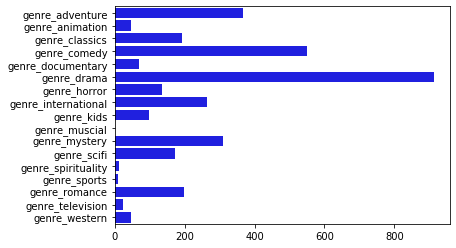

In [39]:
conn = sqlite3.connect('movie.db') 
cur = conn.cursor()

cur.execute(""" 
SELECT r.rating, box_office, genre_action, genre_adventure, genre_animation, genre_classics, 
genre_comedy, genre_documentary, genre_drama, 
genre_horror, genre_international, genre_kids, 
genre_muscial, genre_mystery, genre_scifi, 
genre_spirituality, genre_sports, genre_romance,
genre_television, genre_western
FROM rt_reviews r
JOIN rt_movie_info
USING('pid')  
ORDER BY box_office DESC;""")

dfgBox = pd.DataFrame(cur.fetchall())
dfgBox.columns = (x[0] for x in cur.description)
#dfgBoxList = dfgBox.values.tolist()
cols = list(dfgBox.columns)
genre_cols = cols[3:]
genre_count = {}
for col in genre_cols:
    count = np.sum(dfgBox[col] != '0').sum() 
    genre_count[col] = count
    
genre_count   

keys = list(genre_count.keys())
values = list(genre_count.values())

sns.barplot(y = keys, x = values, color = 'blue')

***Findings***: write summary here